Adapted from https://github.com/hasithsura/Environmental-Sound-Classification/blob/master/ESC50-Pytorch.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Import self-implemented torch dataset
from datasets import BDLibDataset

## Now training and testing on BDLib

In [2]:
train_data = BDLibDataset(root='BDLib', 
                          fold_ids=[1,2],
                          download=True)
valid_data = BDLibDataset(root='BDLib', 
                          fold_ids=[3],
                          download=False)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))

print(train_data.data[0].shape)

Download not needed, files already on disk.
train data length 120
valid data length 60
(1, 128, 431)


In [3]:
from torchvision.models import resnet18
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet18(pretrained=True)
resnet_model.fc = nn.Linear(512, train_data.num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [5]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 25
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  8%|▊         | 2/25 [00:00<00:08,  2.75it/s]

Epoch - 1 Train-Loss : 1.6461598575115204
Epoch - 1 Valid-Loss : 1.992239534854889 Valid-Accuracy : 0.25
Epoch - 2 Train-Loss : 0.42587804421782494
Epoch - 2 Valid-Loss : 0.9816058278083801 Valid-Accuracy : 0.7166666666666667


 16%|█▌        | 4/25 [00:01<00:04,  4.74it/s]

Epoch - 3 Train-Loss : 0.23292440921068192
Epoch - 3 Valid-Loss : 0.8052722737193108 Valid-Accuracy : 0.7333333333333333
Epoch - 4 Train-Loss : 0.1210676385089755
Epoch - 4 Valid-Loss : 0.7308165282011032 Valid-Accuracy : 0.8166666666666667


 24%|██▍       | 6/25 [00:01<00:03,  5.99it/s]

Epoch - 5 Train-Loss : 0.08190183434635401
Epoch - 5 Valid-Loss : 0.8577271103858948 Valid-Accuracy : 0.7166666666666667
Epoch - 6 Train-Loss : 0.09592282271478325
Epoch - 6 Valid-Loss : 0.611432671546936 Valid-Accuracy : 0.8166666666666667


 32%|███▏      | 8/25 [00:01<00:02,  6.67it/s]

Epoch - 7 Train-Loss : 0.07544477377086878
Epoch - 7 Valid-Loss : 0.7427912950515747 Valid-Accuracy : 0.8333333333333334
Epoch - 8 Train-Loss : 0.1365265263011679
Epoch - 8 Valid-Loss : 0.8388202711939812 Valid-Accuracy : 0.7666666666666667


 40%|████      | 10/25 [00:01<00:02,  7.02it/s]

Epoch - 9 Train-Loss : 0.11874760501086712
Epoch - 9 Valid-Loss : 0.7162312716245651 Valid-Accuracy : 0.8333333333333334
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.039821873884648085
Epoch - 10 Valid-Loss : 0.5904885120689869 Valid-Accuracy : 0.85


 48%|████▊     | 12/25 [00:02<00:01,  7.21it/s]

Epoch - 11 Train-Loss : 0.037520580808632076
Epoch - 11 Valid-Loss : 0.6303420439362526 Valid-Accuracy : 0.8666666666666667
Epoch - 12 Train-Loss : 0.11909680266398937
Epoch - 12 Valid-Loss : 0.6024707891047001 Valid-Accuracy : 0.8666666666666667


 56%|█████▌    | 14/25 [00:02<00:01,  7.32it/s]

Epoch - 13 Train-Loss : 0.08249500684905797
Epoch - 13 Valid-Loss : 0.5396973490715027 Valid-Accuracy : 0.8833333333333333
Epoch - 14 Train-Loss : 0.020409387885592878
Epoch - 14 Valid-Loss : 0.5906889140605927 Valid-Accuracy : 0.8833333333333333


 64%|██████▍   | 16/25 [00:02<00:01,  7.36it/s]

Epoch - 15 Train-Loss : 0.01912655943306163
Epoch - 15 Valid-Loss : 0.5642249584197998 Valid-Accuracy : 0.8833333333333333
Epoch - 16 Train-Loss : 0.0298676795209758
Epoch - 16 Valid-Loss : 0.63038170337677 Valid-Accuracy : 0.8666666666666667


 72%|███████▏  | 18/25 [00:02<00:00,  7.39it/s]

Epoch - 17 Train-Loss : 0.012486864347010851
Epoch - 17 Valid-Loss : 0.6029139216989279 Valid-Accuracy : 0.8666666666666667
Epoch - 18 Train-Loss : 0.08211368578486145
Epoch - 18 Valid-Loss : 0.5934503898024559 Valid-Accuracy : 0.8666666666666667


 80%|████████  | 20/25 [00:03<00:00,  7.42it/s]

Epoch - 19 Train-Loss : 0.019607570196967572
Epoch - 19 Valid-Loss : 0.6029965877532959 Valid-Accuracy : 0.85
Changed learning rate to 2e-06
Epoch - 20 Train-Loss : 0.03066719596972689
Epoch - 20 Valid-Loss : 0.5495338402688503 Valid-Accuracy : 0.8666666666666667


 88%|████████▊ | 22/25 [00:03<00:00,  7.43it/s]

Epoch - 21 Train-Loss : 0.03709955618251115
Epoch - 21 Valid-Loss : 0.6007007323205471 Valid-Accuracy : 0.85
Epoch - 22 Train-Loss : 0.02423352369805798
Epoch - 22 Valid-Loss : 0.5866158157587051 Valid-Accuracy : 0.8666666666666667


 96%|█████████▌| 24/25 [00:03<00:00,  7.43it/s]

Epoch - 23 Train-Loss : 0.02331794984638691
Epoch - 23 Valid-Loss : 0.5827529616653919 Valid-Accuracy : 0.8666666666666667
Epoch - 24 Train-Loss : 0.014309256279375404
Epoch - 24 Valid-Loss : 0.5708084627985954 Valid-Accuracy : 0.8666666666666667


100%|██████████| 25/25 [00:03<00:00,  6.36it/s]

Epoch - 25 Train-Loss : 0.013839423656463623
Epoch - 25 Valid-Loss : 0.5518596582114697 Valid-Accuracy : 0.8666666666666667


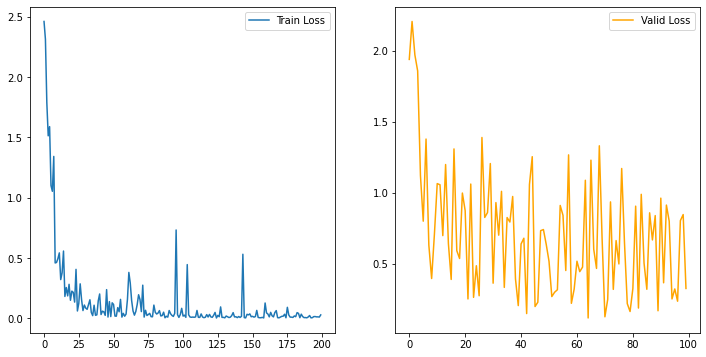

In [6]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
